# Model Training Notebook
## Image Colorization using GAN

This notebook demonstrates the complete training pipeline for the image colorization model.

**Contents:**
1. Setup and Configuration
2. Data Loading
3. Model Initialization
4. Training Loop
5. Training Visualization
6. Model Saving

In [1]:
import os
import sys
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Import from modular structure
from src.models import UNetGenerator, PatchDiscriminator
from src.preprocessing import create_dataloaders
from src.training import Trainer

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"MPS Available: {torch.backends.mps.is_available()}")

PyTorch Version: 2.10.0
CUDA Available: False
MPS Available: False


## 1. Configuration

In [2]:
# Training Configuration
config = {
    # Data
    'data_dir': '../data/train',
    'image_size': 256,
    'batch_size': 8,  # Reduced for faster training
    'val_split': 0.1,
    'test_split': 0.1,
    'num_workers': 0,  # Set to 0 for notebook compatibility
    
    # Training
    'num_epochs': 3,  # Reduced for quick demonstration
    'lr_g': 2e-4,
    'lr_d': 2e-4,
    'beta1': 0.5,
    'beta2': 0.999,
    'l1_lambda': 100,
    
    # Saving
    'save_dir': '../results',
    'checkpoint_every': 1,
}

# Device selection
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")
print("\nConfiguration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Using device: cpu

Configuration:
  data_dir: ../data/train
  image_size: 256
  batch_size: 8
  val_split: 0.1
  test_split: 0.1
  num_workers: 0
  num_epochs: 3
  lr_g: 0.0002
  lr_d: 0.0002
  beta1: 0.5
  beta2: 0.999
  l1_lambda: 100
  save_dir: ../results
  checkpoint_every: 1


## 2. Data Loading

In [3]:
# Create data loaders
train_loader, val_loader, test_loader = create_dataloaders(
    data_dir=config['data_dir'],
    batch_size=config['batch_size'],
    image_size=config['image_size'],
    val_split=config['val_split'],
    test_split=config['test_split'],
    num_workers=config['num_workers']
)

print(f"\nData Loaders Created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

Dataset Split:
  Train: 80 images
  Validation: 10 images
  Test: 10 images

Data Loaders Created:
  Train batches: 10
  Validation batches: 2
  Test batches: 2


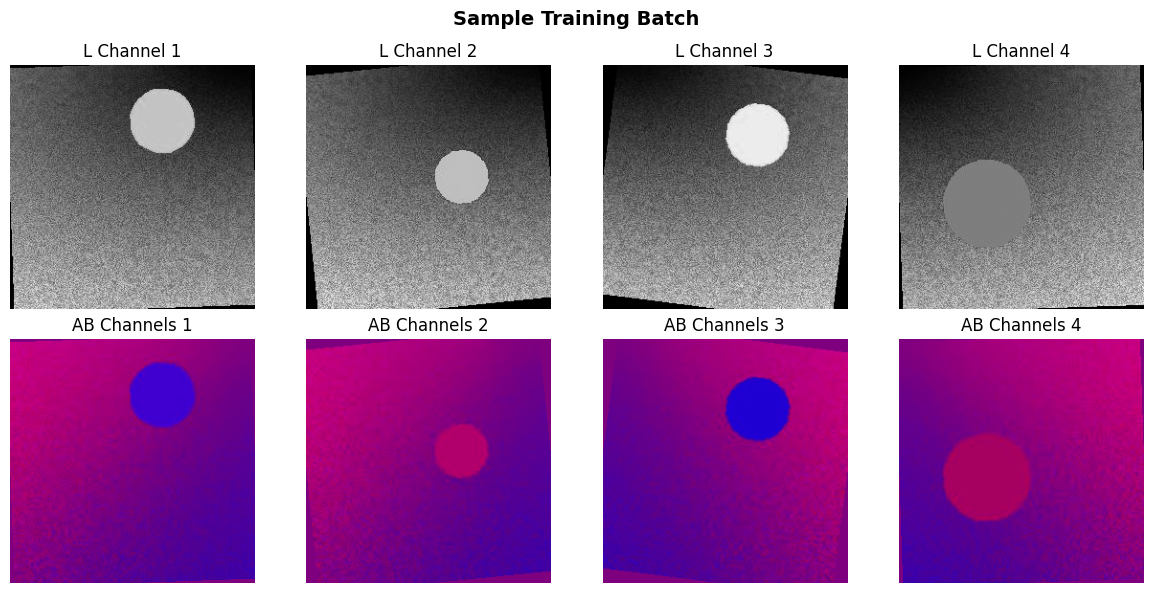

L shape: torch.Size([8, 1, 256, 256])
AB shape: torch.Size([8, 2, 256, 256])
L range: [-1.00, 0.97]
AB range: [-0.78, 0.72]


In [4]:
# Visualize a sample batch
L_sample, AB_sample = next(iter(train_loader))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Sample Training Batch', fontsize=14, fontweight='bold')

for i in range(4):
    # L channel (grayscale)
    axes[0, i].imshow(L_sample[i, 0].numpy(), cmap='gray')
    axes[0, i].set_title(f'L Channel {i+1}')
    axes[0, i].axis('off')
    
    # AB channels (as heatmap)
    ab_vis = np.zeros((256, 256, 3))
    ab_vis[:, :, 0] = (AB_sample[i, 0].numpy() + 1) / 2  # A -> Red
    ab_vis[:, :, 2] = (AB_sample[i, 1].numpy() + 1) / 2  # B -> Blue
    axes[1, i].imshow(ab_vis)
    axes[1, i].set_title(f'AB Channels {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print(f"L shape: {L_sample.shape}")
print(f"AB shape: {AB_sample.shape}")
print(f"L range: [{L_sample.min():.2f}, {L_sample.max():.2f}]")
print(f"AB range: [{AB_sample.min():.2f}, {AB_sample.max():.2f}]")

## 3. Model Initialization

In [5]:
# Initialize models
generator = UNetGenerator(in_channels=1, out_channels=2, features=64).to(device)
discriminator = PatchDiscriminator(in_channels=3, features=64).to(device)

# Count parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:")
print(f"  Generator parameters: {count_params(generator):,}")
print(f"  Discriminator parameters: {count_params(discriminator):,}")
print(f"  Total parameters: {count_params(generator) + count_params(discriminator):,}")

Model Architecture:
  Generator parameters: 54,410,370
  Discriminator parameters: 2,765,633
  Total parameters: 57,176,003


In [6]:
# Test forward pass
with torch.no_grad():
    L_test = L_sample[:1].to(device)
    AB_test = AB_sample[:1].to(device)
    
    # Generator forward
    AB_pred = generator(L_test)
    print(f"Generator input: {L_test.shape}")
    print(f"Generator output: {AB_pred.shape}")
    
    # Discriminator forward
    disc_out = discriminator(L_test, AB_pred)
    print(f"Discriminator output: {disc_out.shape}")

Generator input: torch.Size([1, 1, 256, 256])
Generator output: torch.Size([1, 2, 256, 256])
Discriminator output: torch.Size([1, 1, 30, 30])


## 4. Training

In [7]:
# Initialize trainer
trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    config=config,
    save_dir=config['save_dir']
)

print("Trainer initialized successfully!")

Trainer initialized successfully!


In [8]:
# Start training
print("Starting training...")
print("="*60)

history = trainer.train(
    num_epochs=config['num_epochs'],
    resume_path=None  # Set to checkpoint path to resume training
)

Starting training...
TRAINING CONFIGURATION
Device: cpu
Epochs: 3
Batch Size: 8
Learning Rate (G): 0.0002
Learning Rate (D): 0.0002
L1 Lambda: 100


Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/10 [00:03<?, ?it/s, G=60.252, D=0.703, L1=59.356]

Epoch 1:  10%|█         | 1/10 [00:03<00:30,  3.37s/it, G=60.252, D=0.703, L1=59.356]

Epoch 1:  10%|█         | 1/10 [00:06<00:30,  3.37s/it, G=54.503, D=0.786, L1=53.428]

Epoch 1:  20%|██        | 2/10 [00:06<00:27,  3.39s/it, G=54.503, D=0.786, L1=53.428]

Epoch 1:  20%|██        | 2/10 [00:09<00:27,  3.39s/it, G=48.763, D=0.837, L1=47.899]

Epoch 1:  30%|███       | 3/10 [00:09<00:22,  3.20s/it, G=48.763, D=0.837, L1=47.899]

Epoch 1:  30%|███       | 3/10 [00:12<00:22,  3.20s/it, G=43.521, D=0.709, L1=42.721]

Epoch 1:  40%|████      | 4/10 [00:12<00:18,  3.10s/it, G=43.521, D=0.709, L1=42.721]

Epoch 1:  40%|████      | 4/10 [00:15<00:18,  3.10s/it, G=40.520, D=0.628, L1=39.680]

Epoch 1:  50%|█████     | 5/10 [00:15<00:15,  3.06s/it, G=40.520, D=0.628, L1=39.680]

Epoch 1:  50%|█████     | 5/10 [00:18<00:15,  3.06s/it, G=36.382, D=0.608, L1=35.492]

Epoch 1:  60%|██████    | 6/10 [00:18<00:12,  3.02s/it, G=36.382, D=0.608, L1=35.492]

Epoch 1:  60%|██████    | 6/10 [00:21<00:12,  3.02s/it, G=33.091, D=0.577, L1=32.171]

Epoch 1:  70%|███████   | 7/10 [00:21<00:09,  3.10s/it, G=33.091, D=0.577, L1=32.171]

Epoch 1:  70%|███████   | 7/10 [00:24<00:09,  3.10s/it, G=32.613, D=0.561, L1=31.649]

Epoch 1:  80%|████████  | 8/10 [00:24<00:06,  3.10s/it, G=32.613, D=0.561, L1=31.649]

Epoch 1:  80%|████████  | 8/10 [00:28<00:06,  3.10s/it, G=30.873, D=0.545, L1=29.866]

Epoch 1:  90%|█████████ | 9/10 [00:28<00:03,  3.08s/it, G=30.873, D=0.545, L1=29.866]

Epoch 1:  90%|█████████ | 9/10 [00:31<00:03,  3.08s/it, G=29.894, D=0.511, L1=28.833]

Epoch 1: 100%|██████████| 10/10 [00:31<00:00,  3.06s/it, G=29.894, D=0.511, L1=28.833]

Epoch 1: 100%|██████████| 10/10 [00:31<00:00,  3.10s/it, G=29.894, D=0.511, L1=28.833]


Epoch 1/3
  Train - G: 41.0413, D: 0.6465, L1: 40.1096
  Val   - G: 27.4342, D: 0.6594


  Saved best model (val_g_loss: 27.4342)


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/10 [00:03<?, ?it/s, G=29.411, D=0.492, L1=28.210]

Epoch 2:  10%|█         | 1/10 [00:03<00:28,  3.17s/it, G=29.411, D=0.492, L1=28.210]

Epoch 2:  10%|█         | 1/10 [00:06<00:28,  3.17s/it, G=26.985, D=0.498, L1=25.874]

Epoch 2:  20%|██        | 2/10 [00:06<00:24,  3.11s/it, G=26.985, D=0.498, L1=25.874]

Epoch 2:  20%|██        | 2/10 [00:09<00:24,  3.11s/it, G=26.537, D=0.540, L1=25.347]

Epoch 2:  30%|███       | 3/10 [00:09<00:21,  3.06s/it, G=26.537, D=0.540, L1=25.347]

Epoch 2:  30%|███       | 3/10 [00:12<00:21,  3.06s/it, G=26.591, D=0.495, L1=25.372]

Epoch 2:  40%|████      | 4/10 [00:12<00:18,  3.03s/it, G=26.591, D=0.495, L1=25.372]

Epoch 2:  40%|████      | 4/10 [00:15<00:18,  3.03s/it, G=26.946, D=0.450, L1=25.668]

Epoch 2:  50%|█████     | 5/10 [00:15<00:15,  3.02s/it, G=26.946, D=0.450, L1=25.668]

Epoch 2:  50%|█████     | 5/10 [00:18<00:15,  3.02s/it, G=26.959, D=0.468, L1=25.608]

Epoch 2:  60%|██████    | 6/10 [00:18<00:11,  3.00s/it, G=26.959, D=0.468, L1=25.608]

Epoch 2:  60%|██████    | 6/10 [00:21<00:11,  3.00s/it, G=25.100, D=0.421, L1=23.725]

Epoch 2:  70%|███████   | 7/10 [00:21<00:08,  2.99s/it, G=25.100, D=0.421, L1=23.725]

Epoch 2:  70%|███████   | 7/10 [00:24<00:08,  2.99s/it, G=24.966, D=0.377, L1=23.484]

Epoch 2:  80%|████████  | 8/10 [00:24<00:05,  2.98s/it, G=24.966, D=0.377, L1=23.484]

Epoch 2:  80%|████████  | 8/10 [00:27<00:05,  2.98s/it, G=23.948, D=0.364, L1=22.558]

Epoch 2:  90%|█████████ | 9/10 [00:27<00:02,  2.98s/it, G=23.948, D=0.364, L1=22.558]

Epoch 2:  90%|█████████ | 9/10 [00:30<00:02,  2.98s/it, G=22.954, D=0.363, L1=21.343]

Epoch 2: 100%|██████████| 10/10 [00:30<00:00,  2.98s/it, G=22.954, D=0.363, L1=21.343]

Epoch 2: 100%|██████████| 10/10 [00:30<00:00,  3.01s/it, G=22.954, D=0.363, L1=21.343]


Epoch 2/3
  Train - G: 26.0396, D: 0.4467, L1: 24.7189
  Val   - G: 23.5543, D: 0.7044


  Saved best model (val_g_loss: 23.5543)


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/10 [00:03<?, ?it/s, G=23.159, D=0.366, L1=21.810]

Epoch 3:  10%|█         | 1/10 [00:03<00:29,  3.24s/it, G=23.159, D=0.366, L1=21.810]

Epoch 3:  10%|█         | 1/10 [00:06<00:29,  3.24s/it, G=22.567, D=0.441, L1=20.934]

Epoch 3:  20%|██        | 2/10 [00:06<00:25,  3.24s/it, G=22.567, D=0.441, L1=20.934]

Epoch 3:  20%|██        | 2/10 [00:09<00:25,  3.24s/it, G=21.589, D=0.425, L1=19.967]

Epoch 3:  30%|███       | 3/10 [00:09<00:21,  3.12s/it, G=21.589, D=0.425, L1=19.967]

Epoch 3:  30%|███       | 3/10 [00:12<00:21,  3.12s/it, G=22.227, D=0.420, L1=20.854]

Epoch 3:  40%|████      | 4/10 [00:12<00:18,  3.09s/it, G=22.227, D=0.420, L1=20.854]

Epoch 3:  40%|████      | 4/10 [00:15<00:18,  3.09s/it, G=21.788, D=0.332, L1=20.312]

Epoch 3:  50%|█████     | 5/10 [00:15<00:15,  3.05s/it, G=21.788, D=0.332, L1=20.312]

Epoch 3:  50%|█████     | 5/10 [00:18<00:15,  3.05s/it, G=21.310, D=0.297, L1=19.544]

Epoch 3:  60%|██████    | 6/10 [00:18<00:12,  3.06s/it, G=21.310, D=0.297, L1=19.544]

Epoch 3:  60%|██████    | 6/10 [00:21<00:12,  3.06s/it, G=20.058, D=0.289, L1=18.255]

Epoch 3:  70%|███████   | 7/10 [00:21<00:09,  3.02s/it, G=20.058, D=0.289, L1=18.255]

Epoch 3:  70%|███████   | 7/10 [00:24<00:09,  3.02s/it, G=19.179, D=0.264, L1=17.296]

Epoch 3:  80%|████████  | 8/10 [00:24<00:05,  2.99s/it, G=19.179, D=0.264, L1=17.296]

Epoch 3:  80%|████████  | 8/10 [00:27<00:05,  2.99s/it, G=20.201, D=0.290, L1=18.399]

Epoch 3:  90%|█████████ | 9/10 [00:27<00:02,  2.98s/it, G=20.201, D=0.290, L1=18.399]

Epoch 3:  90%|█████████ | 9/10 [00:30<00:02,  2.98s/it, G=19.668, D=0.243, L1=17.643]

Epoch 3: 100%|██████████| 10/10 [00:30<00:00,  2.96s/it, G=19.668, D=0.243, L1=17.643]

Epoch 3: 100%|██████████| 10/10 [00:30<00:00,  3.03s/it, G=19.668, D=0.243, L1=17.643]


Epoch 3/3
  Train - G: 21.1745, D: 0.3366, L1: 19.5015
  Val   - G: 19.5680, D: 0.7409


  Saved best model (val_g_loss: 19.5680)



TRAINING COMPLETE


## 5. Training Visualization

Saved to: ../results/plots/training_history.png


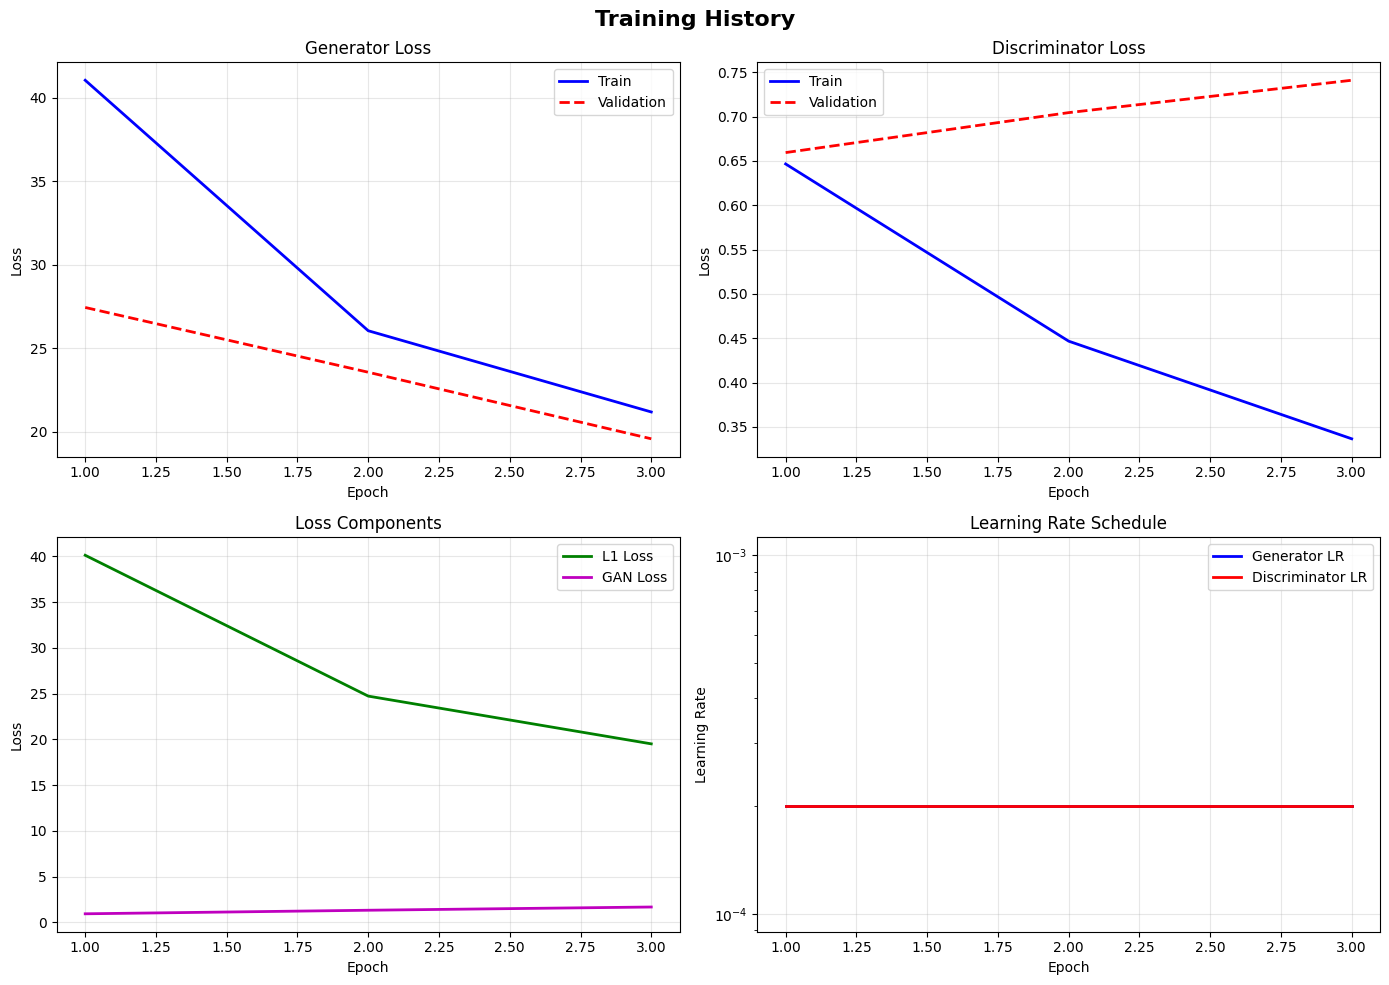

In [9]:
# Plot training history
# Load history from checkpoint if not in memory
if 'history' not in dir() or history is None:
    import json
    checkpoint_path = '../results/checkpoints/best_model.pth'
    history_path = '../results/training_history.json'
    
    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            history = json.load(f)
        print(f"Loaded history from {history_path}")
    elif os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        history = checkpoint.get('history', None)
        print(f"Loaded history from checkpoint: {checkpoint_path}")
    else:
        print("No training history found. Please run training first.")
        history = None

if history and len(history.get('train_g_loss', [])) > 0:
    from src.utils import plot_training_history
    
    plot_training_history(
        history,
        save_path='../results/plots/training_history.png',
        show=True
    )
else:
    print("No training data available to plot.")

In [10]:
# Display training summary
if history and len(history.get('train_g_loss', [])) > 0:
    print("="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Total Epochs: {len(history['train_g_loss'])}")
    print(f"")
    print(f"Generator Loss:")
    print(f"  Initial: {history['train_g_loss'][0]:.4f}")
    print(f"  Final:   {history['train_g_loss'][-1]:.4f}")
    print(f"  Best:    {min(history['val_g_loss']):.4f}")
    print(f"")
    print(f"Discriminator Loss:")
    print(f"  Initial: {history['train_d_loss'][0]:.4f}")
    print(f"  Final:   {history['train_d_loss'][-1]:.4f}")
    print("="*60)
else:
    print("No training history available. Run training first.")

TRAINING SUMMARY
Total Epochs: 3

Generator Loss:
  Initial: 41.0413
  Final:   21.1745
  Best:    19.5680

Discriminator Loss:
  Initial: 0.6465
  Final:   0.3366


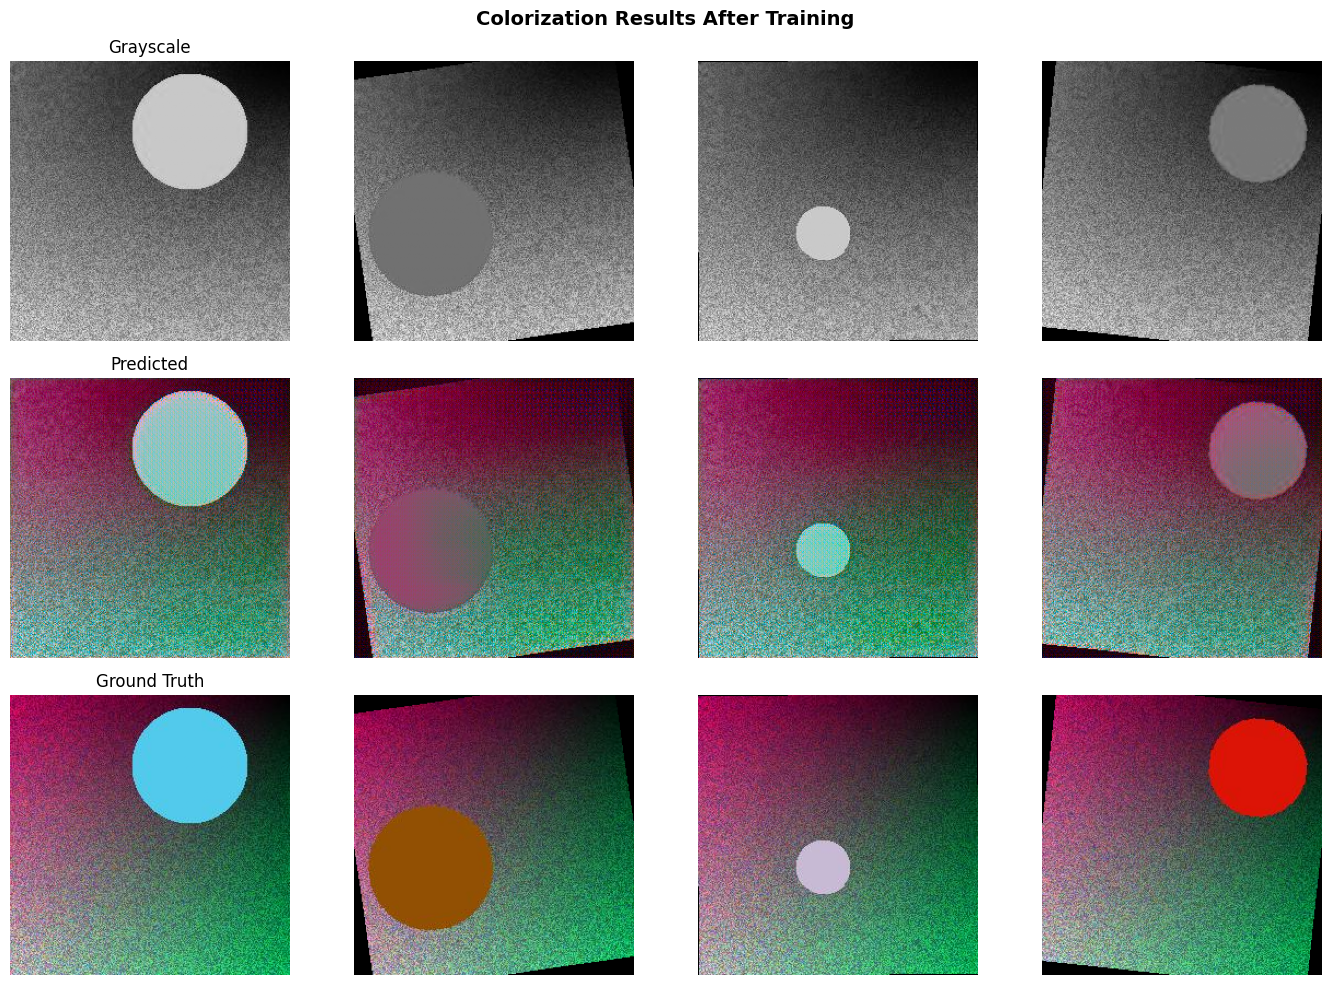

In [11]:
# Visualize sample predictions after training
generator.eval()

from src.utils import lab2rgb, denormalize_lab

fig, axes = plt.subplots(3, 4, figsize=(14, 10))
fig.suptitle('Colorization Results After Training', fontsize=14, fontweight='bold')

with torch.no_grad():
    for batch_idx, (L, AB_real) in enumerate(test_loader):
        if batch_idx >= 1:
            break
            
        L = L.to(device)
        AB_pred = generator(L)
        
        for i in range(min(4, L.size(0))):
            L_np = L[i].cpu().numpy().transpose(1, 2, 0)
            AB_pred_np = AB_pred[i].cpu().numpy().transpose(1, 2, 0)
            AB_real_np = AB_real[i].numpy().transpose(1, 2, 0)
            
            lab_pred = denormalize_lab(L_np, AB_pred_np)
            lab_real = denormalize_lab(L_np, AB_real_np)
            
            rgb_pred = lab2rgb(lab_pred)
            rgb_real = lab2rgb(lab_real)
            
            # Grayscale
            axes[0, i].imshow(L_np.squeeze(), cmap='gray')
            axes[0, i].set_title('Grayscale' if i == 0 else '')
            axes[0, i].axis('off')
            
            # Predicted
            axes[1, i].imshow(np.clip(rgb_pred, 0, 1))
            axes[1, i].set_title('Predicted' if i == 0 else '')
            axes[1, i].axis('off')
            
            # Ground Truth
            axes[2, i].imshow(np.clip(rgb_real, 0, 1))
            axes[2, i].set_title('Ground Truth' if i == 0 else '')
            axes[2, i].axis('off')

axes[0, 0].set_ylabel('Input', fontsize=12)
axes[1, 0].set_ylabel('Output', fontsize=12)
axes[2, 0].set_ylabel('Target', fontsize=12)

plt.tight_layout()
plt.savefig('../results/plots/training_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Save Final Model

In [12]:
# Save final models
os.makedirs('../trained_models', exist_ok=True)

torch.save(generator.state_dict(), '../trained_models/generator_final.pth')
torch.save(discriminator.state_dict(), '../trained_models/discriminator_final.pth')

print("Models saved to trained_models/")
print(f"  - generator_final.pth")
print(f"  - discriminator_final.pth")

Models saved to trained_models/
  - generator_final.pth
  - discriminator_final.pth


## Training Complete

The model has been trained successfully. You can now:
1. Run the evaluation notebook (`03_Evaluation.ipynb`) for detailed metrics
2. Use the Gradio UI (`python app.py`) for interactive testing
3. Use the inference script (`python inference.py`) for batch processing